# Testing for CuW-ACE potential

# load some packages

In [1]:
from amstools import *
from pyace import *
import shutil
import os
import glob
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bcc110, bcc100, bcc111, fcc100, fcc110, fcc111
from ase.visualize import view
from ase.build import surface, bulk
from ase.io import write, read
from collections import Counter
from pyace.preparedata import calc_min_distance,aseatoms_to_atomicenvironment
from matplotlib.colors import LinearSegmentedColormap
from math import pi

# Dataset

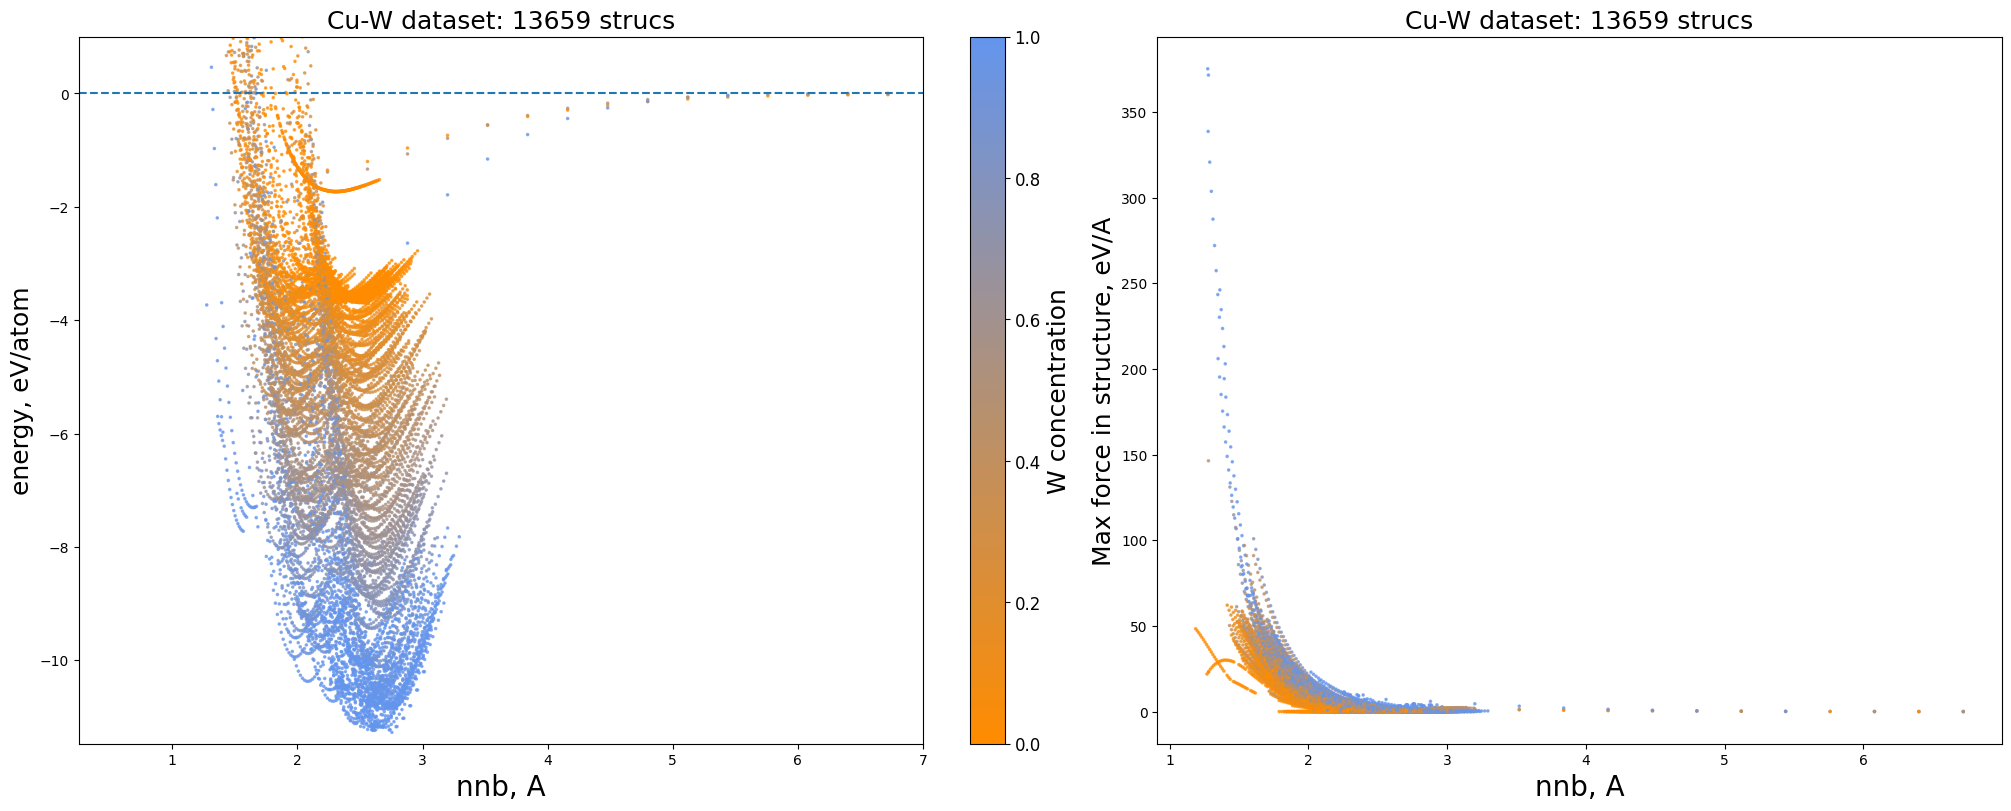

In [2]:
# 设置元素信息
elem1 = "Cu"
elem2 = "W"
# 读取数据集
df_binary = pd.read_pickle("./dataset/CuW_all.pckl.gzip",compression="gzip")

def process_df(df, elem1=elem1, elem2=elem2):
    # single-atom energies of Cu and W (IN ORDER!)
    e0_array = np.array([-0.017568369, -1.6833144])  # Cu, W

    df["NUMBER_OF_ATOMS"] = df["ase_atoms"].map(len)

    if "energy" in df.columns:
        df["energy_per_atom"] = df["energy"] / df["NUMBER_OF_ATOMS"]

    df["comp_dict"] = df["ase_atoms"].map(lambda at: Counter(at.get_chemical_symbols()))
    df["n%s" % elem1] = df["comp_dict"].map(lambda d: d.get("%s" % elem1, 0))
    df["n%s" % elem2] = df["comp_dict"].map(lambda d: d.get("%s" % elem2, 0))
    df["c%s" % elem2] = df["n%s" % elem2] / df["NUMBER_OF_ATOMS"]
    df["c%s" % elem1] = df["n%s" % elem1] / df["NUMBER_OF_ATOMS"]

    if "energy_corrected" not in df.columns:
        df["energy_corrected"] = df["energy"] - np.sum(df[["n%s" % elem1, "n%s" % elem2]].values * e0_array, axis=1)
        df["energy_corrected_per_atom"] = df["energy_corrected"] / df["NUMBER_OF_ATOMS"]

    if "atomic_env" not in df.columns:
        df["atomic_env"] = df["ase_atoms"].apply(aseatoms_to_atomicenvironment, args=(7.,))
    df["nnb"] = df["atomic_env"].apply(calc_min_distance)


process_df(df_binary)

from matplotlib import cm
import matplotlib as mpl

def get_max_F(forces):
    return max([max(f) for f in forces])

df_binary["F"] = df_binary["forces"].apply(get_max_F)

#fig, (ax, bx) = plt.subplots(dpi=150)
fig, (ax, bx) = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

e0 = df_binary["energy_corrected_per_atom"].min()

colors = ['darkorange', 'cornflowerblue']
#colors = ['gold', 'blue']
n_bins = 100  # 分成100个颜色
cmap_name = "red_to_green"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

ax.scatter(df_binary["nnb"], df_binary["energy_corrected_per_atom"],
           marker=".",
           c=df_binary["c%s" % elem2],  # 使用c%s列的值来映射颜色
           cmap=custom_cmap,  # 使用自定义渐变色映射
           alpha=0.7,
           s=10
           )
bx.scatter(df_binary["nnb"], df_binary["F"],
           marker=".",
           c=df_binary["c%s" % elem2],  # 使用c%s列的值来映射颜色
           cmap=custom_cmap,  # 使用自定义渐变色映射
           alpha=0.7,
           s=10
           )

norm = mpl.colors.Normalize(df_binary["c%s" % elem2].min(), df_binary["c%s" % elem1].max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel(r"%s concentration" % elem2, fontsize=18)

ax.axhline(0, ls="--")

ax.set_ylim(e0 - .2, 1)
ax.set_xlim(0.25, 7)

ax.set_xlabel("nnb, A", fontsize=20)
ax.set_ylabel("energy, eV/atom", fontsize=18)
ax.set_title("%s-%s dataset: %d strucs" % (elem1, elem2, len(df_binary)), fontsize=18)

bx.set_xlabel("nnb, A", fontsize=20)
bx.set_ylabel("Max force in structure, eV/A", fontsize=18)
bx.set_title("%s-%s dataset: %d strucs" % (elem1, elem2, len(df_binary)), fontsize=18)

plt.savefig("Dataset_CuW.png")
plt.show()

# 常数设置

In [3]:
# eV 转 J 
eV_to_J = 1.6022e-19
# eV 转 mJ 
eV_to_mJ = 1.6022e-16
# m 转 A
A_to_m = 1e-10
# eV/A3 转 GPa
eV_per_A3_to_GPa=160.21773

# 势函数参数设置

In [4]:
# Parameter file
model = "./potential/output_potentialbest.yaml"
rcut=7.0
# Define the ASE calculator
calc = PyACECalculator(model)

# 程序运行文件夹

In [5]:
# Save starting directory
save_cwd=os.getcwd()
print("Current directory: ",save_cwd)
# Set where lammps calculations will be done
tmp_dir="./run"
# Better remove whatever is left there
shutil.rmtree(tmp_dir, ignore_errors = True)
print("Calculations will run in directory: ",tmp_dir)
if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)

Current directory:  /home/jiahaopan
Calculations will run in directory:  ./run


# 单质性质测试

## Cu

### 初始设置

In [6]:
# Element name and the expected equilibrium crystal structure
elm = "Cu"
equilstruc = "fcc"

### 晶格常数计算

In [7]:
# Use ams_tools dictionary of structures
struc_tmp=get_structures_dictionary(elm, include=equilstruc)
struc_ini = struc_tmp[equilstruc]["atoms"]
# Optimize the initial structure
struc_ini.set_calculator(calc)
optimizer=SpecialOptimizer(struc_ini)
struc_opt = optimizer.run()
struc_opt.set_calculator(calc)
en_opt=struc_opt.get_potential_energy()/len(struc_opt)
E_refer_Cu = en_opt
stress_opt=struc_opt.get_stress()*eV_per_A3_to_GPa
f_opt=struc_opt.get_forces()
fmax_opt = 0
for i in f_opt:
    fval = (float(i[0])**2 + float(i[1])**2 + float(i[2])**2)**(1./2.)
    if fval > fmax_opt:
        fmax_opt = fval
lattice_opt = (struc_opt.cell.lengths()[0])*2/(2**(1/2))
#opt_information = {"opt_structure": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


In [8]:
print("Lattice paramater : %6.4f A"% (lattice_opt))

Lattice paramater : 3.6356 A


### 表面能

In [9]:
# 创建表面模型
slab100 = fcc100(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab110 = fcc110(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab111 = fcc111(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)

In [10]:
# 修改周期性边界条件
slab100.pbc = [True, True, True]
slab110.pbc = [True, True, True]
slab111.pbc = [True, True, True]

In [11]:
slab100.set_calculator(calc)
slab110.set_calculator(calc)
slab111.set_calculator(calc)
en_slab100=slab100.get_potential_energy()
en_slab110=slab110.get_potential_energy()
en_slab111=slab111.get_potential_energy()

In [12]:
surface100=(en_slab100-(en_opt)/len(struc_opt)*len(slab100))/(slab100.cell[0][0]*slab100.cell[1][1]-slab100.cell[0][1]*slab100.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface110=(en_slab110-(en_opt)/len(struc_opt)*len(slab110))/(slab110.cell[0][0]*slab110.cell[1][1]-slab110.cell[0][1]*slab110.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface111=(en_slab111-(en_opt)/len(struc_opt)*len(slab111))/(slab111.cell[0][0]*slab111.cell[1][1]-slab111.cell[0][1]*slab111.cell[1][0])*eV_to_J/A_to_m/A_to_m/2

In [13]:
print("Surface(100) energy  : %6.4f J/m2"% (surface100))
print("Surface(110) energy  : %6.4f J/m2"% (surface110))
print("Surface(111) energy  : %6.4f J/m2"% (surface111))

Surface(100) energy  : 1.4371 J/m2
Surface(110) energy  : 1.5767 J/m2
Surface(111) energy  : 1.2867 J/m2


### 弹性常数

In [14]:
# calculate the elastic matrix
elmat = ElasticMatrixCalculator(struc_opt)
elmat.calculate()

In [15]:
# print elastic constants and judge the stability of this structure 
print("\n-----------------------------------------")
print("Elastic constants")
print("C11 = %4.0f GPa"% elmat.VALUE["C"][0,0])
print("C12 = %4.0f GPa"% elmat.VALUE["C"][0,1])
print("C44 = %4.0f GPa"% elmat.VALUE["C"][3,3])
print("BV  = %4.0f GPa"% elmat.VALUE["BV"])

print("\nCauchy pressure")
print("C12-C44 = %4.0f GPa"% (elmat.VALUE["C"][0,1]-elmat.VALUE["C"][3,3]))

print("\nBorn stability criteria for cubic crystals")
print("C11-C12 >0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]-elmat.VALUE["C"][0,1]))
print("C11+2C12>0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]+2*elmat.VALUE["C"][0,1]))
print("C44>0      : %4.0f GPa"% elmat.VALUE["C"][3,3])
print("-----------------------------------------")


-----------------------------------------
Elastic constants
C11 =  177 GPa
C12 =  122 GPa
C44 =   79 GPa
BV  =  140 GPa

Cauchy pressure
C12-C44 =   43 GPa

Born stability criteria for cubic crystals
C11-C12 >0 :   55 GPa
C11+2C12>0 :  420 GPa
C44>0      :   79 GPa
-----------------------------------------


### 空位形成能

In [16]:
# calculate the vacancy formation energy
vacancy_calculator = DefectFormationCalculator(struc_opt)
vacancy_calculator.calculate()

ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
! BA

In [17]:
# print vacancy formation energy
print("-----------------------------------------")
print("Vacancy formation energies")
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    print("Site/type: %10s"%i," :: Energy: %6.3f eV"% en_vac_ace)
print("-----------------------------------------")

-----------------------------------------
Vacancy formation energies
Site/type:   a_static  :: Energy:  1.127 eV
Site/type:   a_atomic  :: Energy:  1.096 eV
Site/type:    a_total  :: Energy:  1.089 eV
-----------------------------------------


### 声子谱

Text(0, 0.5, 'Phonon DOS, THz$^{-1}$')

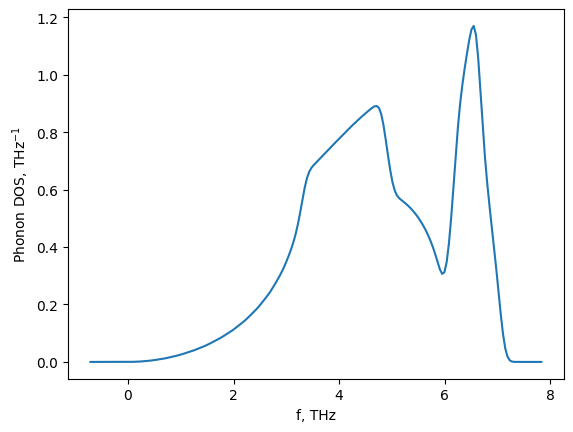

In [18]:
# calculate phonon
phonon_calculator = PhonopyCalculator(struc_opt)
phonon_calculator.calculate()
plt.plot(phonon_calculator.VALUE["dos_energies"], phonon_calculator.VALUE["dos_total"])
plt.xlabel("f, THz")
plt.ylabel("Phonon DOS, THz$^{-1}$")

In [19]:
# FCC high symmetry paths of the first Brillouin zone
path_fcc = [[[0, 0, 0], [0.5, 0, 0.5], [0.625, 0.25, 0.625],
        [0.375, 0.375, 0.75], [0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.25, 0.75]]]
labels_fcc = ["G", "X", "U", "K", "G", "L", "W"]

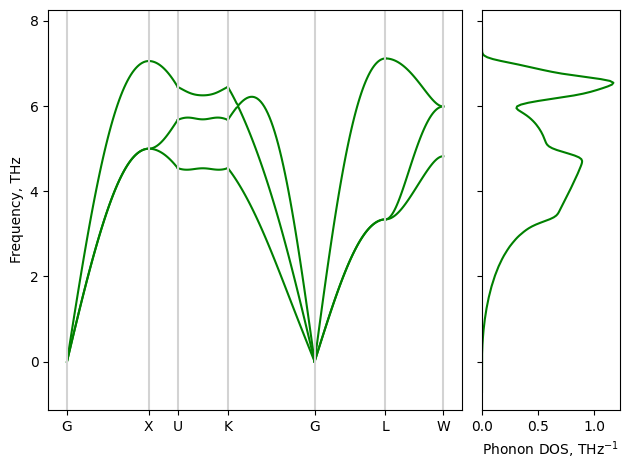

In [20]:
# phonon calculation of fcc structure
phonon_calculator.plot_band_structure_and_dos(path_fcc, labels_fcc, plot_kwargs={"color":"green"})
#plt.savefig("Frequency_fcc.png")

### E-V曲线

In [21]:
# Choose structures for E-V plot (Murnaghan)
s_murn=["hcp","fcc","bcc","dhcp"]

# 设置体积范围
Veq = 12
delV = 2
volume_range=[Veq-delV,Veq+delV]

In [22]:
strucs_murn=get_structures_dictionary(elm, include=s_murn)
murn={}
for struc in strucs_murn:
    print(struc)
    at=strucs_murn[struc]['atoms']
    at.set_calculator(calc)
    murn[struc]={"vol":[],"ene":[],"pre":[]}   
    vr = np.array(volume_range)*len(at)
    murn_calculator = MurnaghanCalculator(at,num_of_point=21,volume_range=vr)
    murn_calculator.calculate()
    murn[struc]["vol"]=murn_calculator.VALUE["volume"]/len(at)
    murn[struc]["ene"]=murn_calculator.VALUE["energy"]/len(at)
    murn[struc]["pre"]=murn_calculator.VALUE["pressure"]*eV_per_A3_to_GPa
    murn[struc]["eqstruc"]=murn_calculator.get_final_structure()

fcc
bcc
hcp
dhcp


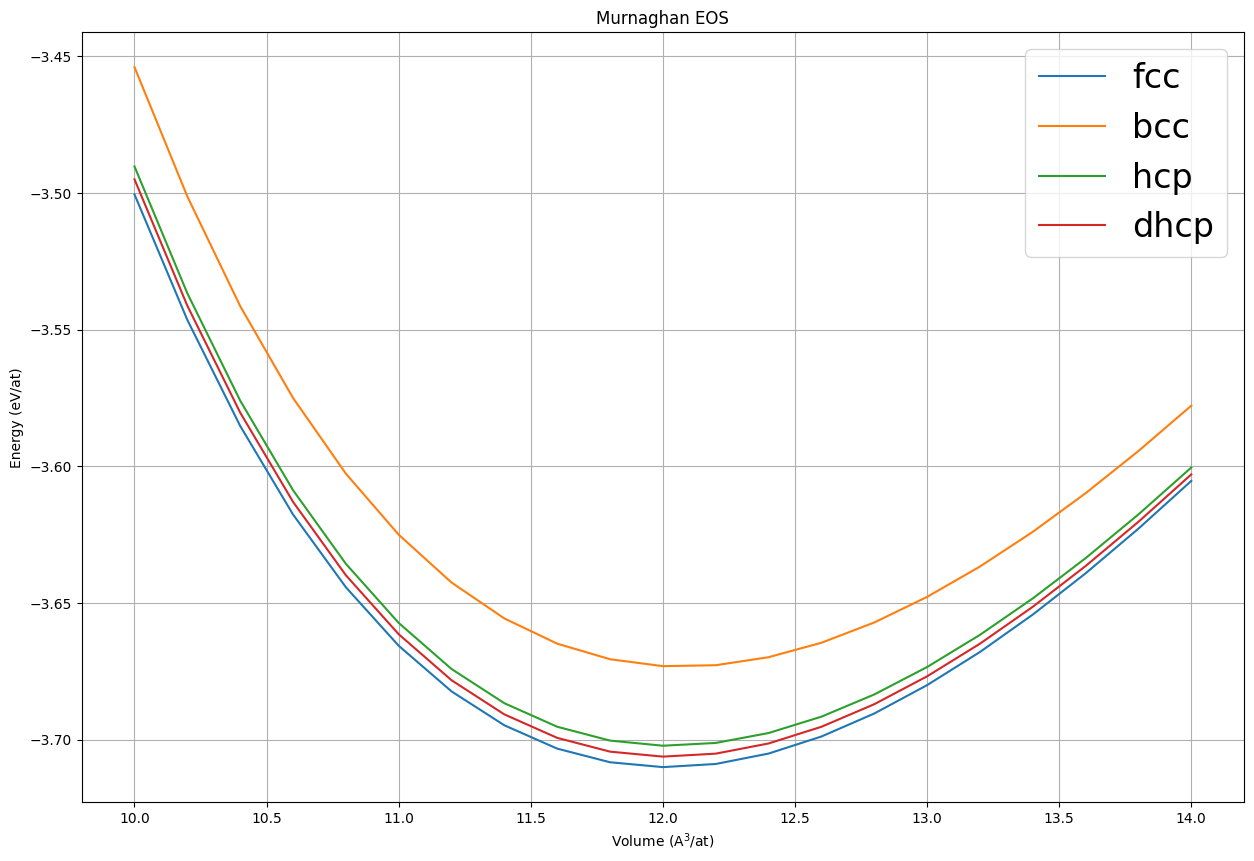

In [23]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["vol"],murn[struc]["ene"],label=struc)
plt.xlabel("Volume (A$^3$/at)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})

### E-P曲线

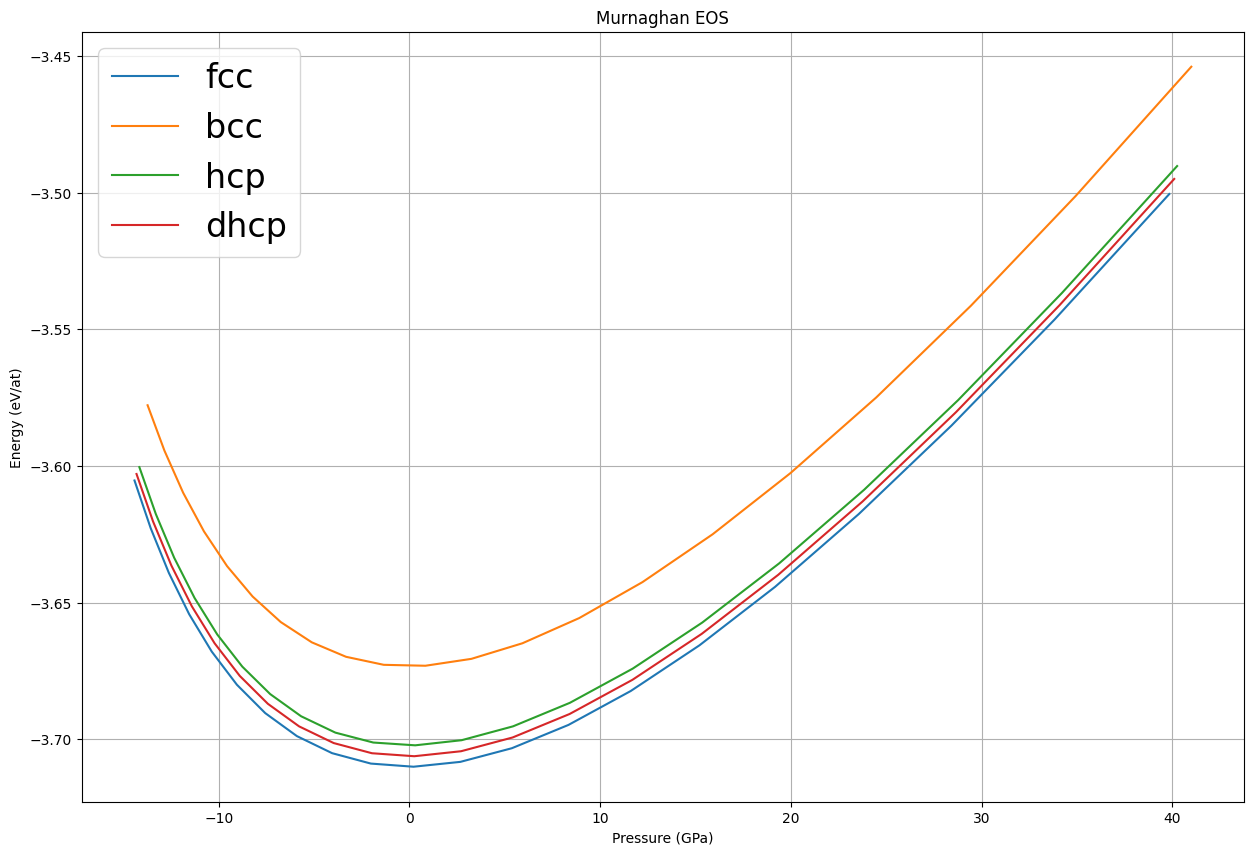

In [24]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["pre"],murn[struc]["ene"],label=struc)
plt.xlabel("Pressure (GPa)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
#plt.savefig("Energy_vs_Pressure.png")

### 构型信息

In [25]:
d = {}
for struc in strucs_murn:
    at=strucs_murn[struc]['atoms']
    stress_tmp=murn[struc]["eqstruc"].get_stress()*eV_per_A3_to_GPa*1000
    energy_tmp=murn[struc]["eqstruc"].get_potential_energy()/len(at)
    d1 = {struc:{'Latpars[A]': murn[struc]["eqstruc"].cell.lengths(), 'Principal stresses[MPa]': stress_tmp[0:3], 'Energy[eV]': energy_tmp}}
    d.update(d1)

In [26]:
dict2data = pd.DataFrame.from_dict(d, orient='index')
dict2data

,Latpars[A],Principal stresses[MPa],Energy[eV]
fcc,"[2.5710815038697725, 2.5710815038697725, 2.571...","[-3.9355038636531314, -3.9355038636531066, -3....",-3.710059
bcc,"[2.5031493827065243, 2.5031493827065243, 2.503...","[-8.682176363548646, -8.682176363549207, -8.68...",-3.673299
hcp,"[2.571683214356912, 2.571683214356912, 4.19954...","[242.2275282565493, 242.22752825651213, -480.3...",-3.702242
dhcp,"[2.571376777492521, 2.571376777492521, 8.39808...","[105.0287955938361, 105.02879559381174, -203.7...",-3.706222


### Transformation paths

In [27]:
# Get the bcc structure and rescale it to the volume of the equilibrium fcc
struc_tmp = get_structures_dictionary(elm, include="bcc")
struc_bcc = struc_tmp["bcc"]["atoms"]
v_fcc = struc_opt.get_volume()
v_bcc = struc_bcc.get_volume()

cell = struc_bcc.get_cell()
new_cell = (v_fcc/v_bcc)**(1.0/3.0)*cell
struc_bcc.set_cell(new_cell, scale_atoms=True)
struc_bcc.set_calculator(calc)

trans_path_trig  = TransformationPathCalculator(struc_bcc, transformation_type="trigonal",num_of_point=100)
trans_path_hex   = TransformationPathCalculator(struc_bcc, transformation_type="hexagonal",num_of_point=100)
trans_path_tetra = TransformationPathCalculator(struc_bcc, transformation_type="tetragonal",num_of_point=100)
trans_path_ortho = TransformationPathCalculator(struc_bcc, transformation_type="orthogonal",num_of_point=100)
trans_path_trig.calculate()
trans_path_hex.calculate()
trans_path_tetra.calculate()
trans_path_ortho.calculate()

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


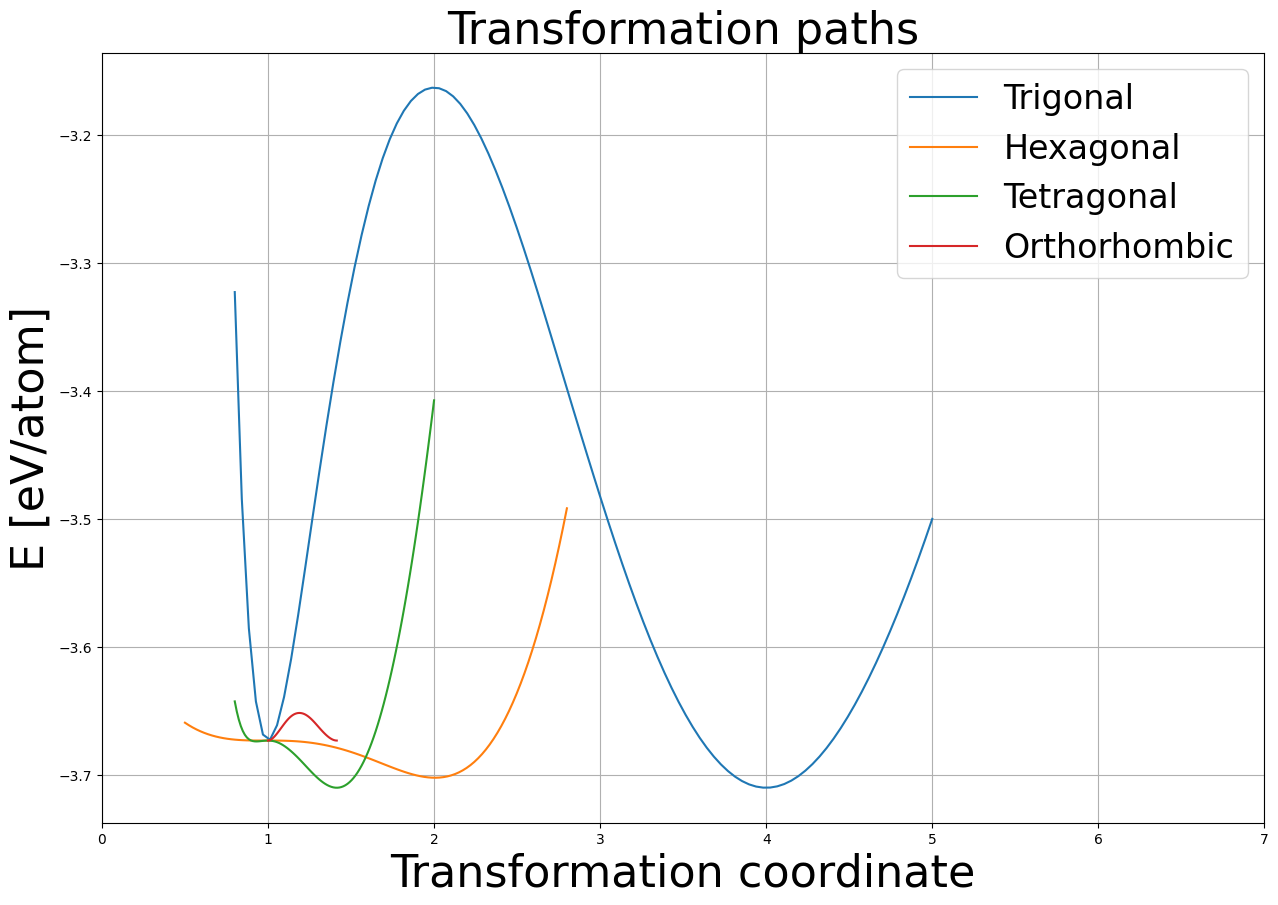

In [28]:
plt.figure(figsize=(15,10))
plt.plot(trans_path_trig.value['transformation_coordinates'],trans_path_trig.value['energies_0']/2.0,label="Trigonal")
plt.plot(trans_path_hex.value['transformation_coordinates']+1,trans_path_hex.value['energies_0']/4.0,label="Hexagonal")
plt.plot(trans_path_tetra.value['transformation_coordinates'],trans_path_tetra.value['energies_0']/2.0,label="Tetragonal")
plt.plot(trans_path_ortho.value['transformation_coordinates'],trans_path_ortho.value['energies_0']/4.0,label="Orthorhombic")

plt.title("Transformation paths", fontsize=32)
#plt.ylim(-4,-3)
plt.xlim(0,7)
plt.xlabel("Transformation coordinate", fontsize=32)
plt.ylabel("E [eV/atom]", fontsize=32)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
plt.savefig("Energy_vs_Transformation_coordinate.png")

### 基础性质总结-DFT对比

In [29]:
# ACE 信息
# lattice etc
opt_information = {"ACE": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}
# elastic constant
opt_information['ACE']['C11'] = elmat.VALUE["C"][0,0]
opt_information['ACE']['C22'] = elmat.VALUE["C"][0,1]
opt_information['ACE']['C33'] = elmat.VALUE["C"][3,3]
# bulk mudule
opt_information['ACE']['B'] = elmat.VALUE["BV"]
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    opt_information['ACE']["%10s"%i] = en_vac_ace
# surface energy
opt_information['ACE']['Surface(100) energy (J/m2)'] = surface100
opt_information['ACE']['Surface(110) energy (J/m2)'] = surface110
opt_information['ACE']['Surface(111) energy (J/m2)'] = surface111

In [30]:
# DFT 信息
# lattice etc
DFT_information = {"DFT": {"element": elm, "equil_structure": 'fcc', "No. of atoms": '1', "Lattice": '3.635', "Energy": '-3.7253', "Maximum force": '0'}}
# elastic constant
DFT_information['DFT']['C11'] = '178'
DFT_information['DFT']['C22'] = '123'
DFT_information['DFT']['C33'] = '75'
# bulk mudule
DFT_information['DFT']['B'] = '141'
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    DFT_information['DFT']["%10s"%i] = '1.07'
# surface energy
DFT_information['DFT']['Surface(100) energy (J/m2)'] = '1.51'
DFT_information['DFT']['Surface(110) energy (J/m2)'] = '1.57'
DFT_information['DFT']['Surface(111) energy (J/m2)'] = '1.36'

In [31]:
opt_information.update(DFT_information)
dict_conclusion = pd.DataFrame.from_dict(opt_information)
dict_conclusion

,ACE,DFT
element,Cu,Cu
equil_structure,fcc,fcc
No. of atoms,1,1
Lattice,3.635615,3.635
Dimensions,"[2.5707683246621307, 2.5707683246621307, 2.570...",NaN
Angles,"[60.00000000000001, 60.00000000000001, 60.0000...",NaN
Energy,-3.710058,-3.7253
Maximum force,0,0
Stress 11,-0.05499930973835911,NaN
Stress 22,-0.05499930973835946,NaN


### 雷达图

In [32]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [33]:
#设置数据
df = {'Relative error':{}}
for key, value in dict_conclusion['DFT'].items():
    if not pd.isnull(value) and is_number(value) and value != '0':
        df['Relative error'][key] = (float(dict_conclusion['ACE'][key])-float(dict_conclusion['DFT'][key]))/float(dict_conclusion['DFT'][key])*100
    else:
        pass

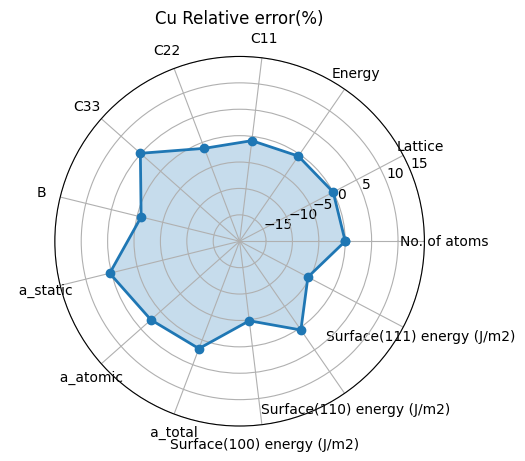

In [34]:
feature = list(df['Relative error'].keys())
values = list(df['Relative error'].values())
angles=np.linspace(0, 2*np.pi,len(feature), endpoint=False)
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))
# 绘图
fig=plt.figure()
# 设置为极坐标格式
ax = fig.add_subplot(111, polar=True)
# 绘制折线图
ax.plot(angles, values, 'o-', linewidth=2)
# 填充颜色
ax.fill(angles, values, alpha=0.25)
  
# 设置雷达图的范围
ax.set_ylim(-20,15)
# 添加标题
plt.title('Cu Relative error(%)')
# 添加网格线
ax.grid(True)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature)
plt.show()


# W

### 初始设置

In [35]:
# Element name and the expected equilibrium crystal structure
elm = "W"
equilstruc = "bcc"

### 晶格常数计算

In [36]:
# Use ams_tools dictionary of structures
struc_tmp=get_structures_dictionary(elm, include=equilstruc)
struc_ini = struc_tmp[equilstruc]["atoms"]
# Optimize the initial structure
struc_ini.set_calculator(calc)
optimizer=SpecialOptimizer(struc_ini)
struc_opt = optimizer.run()
struc_opt.set_calculator(calc)
en_opt=struc_opt.get_potential_energy()/len(struc_opt)
stress_opt=struc_opt.get_stress()*eV_per_A3_to_GPa
f_opt=struc_opt.get_forces()
fmax_opt = 0
E_refer_W = en_opt
for i in f_opt:
    fval = (float(i[0])**2 + float(i[1])**2 + float(i[2])**2)**(1./2.)
    if fval > fmax_opt:
        fmax_opt = fval
lattice_opt = (struc_opt.cell.lengths()[0])*2/(3**(1/2))
#opt_information = {"opt_structure": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


In [37]:
print("Lattice paramater : %6.4f A"% (lattice_opt))

Lattice paramater : 3.1863 A


### 表面能

In [38]:
# 创建表面模型
slab100 = bcc100(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab110 = bcc110(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab111 = bcc111(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)

In [39]:
# 修改周期性边界条件
slab100.pbc = [True, True, True]
slab110.pbc = [True, True, True]
slab111.pbc = [True, True, True]

In [40]:
slab100.set_calculator(calc)
slab110.set_calculator(calc)
slab111.set_calculator(calc)
en_slab100=slab100.get_potential_energy()
en_slab110=slab110.get_potential_energy()
en_slab111=slab111.get_potential_energy()

In [41]:
surface100=(en_slab100-(en_opt)/len(struc_opt)*len(slab100))/(slab100.cell[0][0]*slab100.cell[1][1]-slab100.cell[0][1]*slab100.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface110=(en_slab110-(en_opt)/len(struc_opt)*len(slab110))/(slab110.cell[0][0]*slab110.cell[1][1]-slab110.cell[0][1]*slab110.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface111=(en_slab111-(en_opt)/len(struc_opt)*len(slab111))/(slab111.cell[0][0]*slab111.cell[1][1]-slab111.cell[0][1]*slab111.cell[1][0])*eV_to_J/A_to_m/A_to_m/2

In [42]:
print("Surface(100) energy  : %6.4f J/m2"% (surface100))
print("Surface(110) energy  : %6.4f J/m2"% (surface110))
print("Surface(111) energy  : %6.4f J/m2"% (surface111))

Surface(100) energy  : 4.1323 J/m2
Surface(110) energy  : 3.3690 J/m2
Surface(111) energy  : 3.8358 J/m2


### 弹性常数

In [43]:
# calculate the elastic matrix
elmat = ElasticMatrixCalculator(struc_opt)
elmat.calculate()

In [44]:
# print elastic constants and judge the stability of this structure 
print("\n-----------------------------------------")
print("Elastic constants")
print("C11 = %4.0f GPa"% elmat.VALUE["C"][0,0])
print("C12 = %4.0f GPa"% elmat.VALUE["C"][0,1])
print("C44 = %4.0f GPa"% elmat.VALUE["C"][3,3])
print("BV  = %4.0f GPa"% elmat.VALUE["BV"])

print("\nCauchy pressure")
print("C12-C44 = %4.0f GPa"% (elmat.VALUE["C"][0,1]-elmat.VALUE["C"][3,3]))

print("\nBorn stability criteria for cubic crystals")
print("C11-C12 >0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]-elmat.VALUE["C"][0,1]))
print("C11+2C12>0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]+2*elmat.VALUE["C"][0,1]))
print("C44>0      : %4.0f GPa"% elmat.VALUE["C"][3,3])
print("-----------------------------------------")


-----------------------------------------
Elastic constants
C11 =  528 GPa
C12 =  179 GPa
C44 =  147 GPa
BV  =  295 GPa

Cauchy pressure
C12-C44 =   32 GPa

Born stability criteria for cubic crystals
C11-C12 >0 :  349 GPa
C11+2C12>0 :  886 GPa
C44>0      :  147 GPa
-----------------------------------------


### 空位形成能

In [45]:
# calculate the vacancy formation energy
vacancy_calculator = DefectFormationCalculator(struc_opt)
vacancy_calculator.calculate()

ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
! BA

In [46]:
# print vacancy formation energy
print("-----------------------------------------")
print("Vacancy formation energies")
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    print("Site/type: %10s"%i," :: Energy: %6.3f eV"% en_vac_ace)
print("-----------------------------------------")

-----------------------------------------
Vacancy formation energies
Site/type:   a_static  :: Energy:  3.682 eV
Site/type:   a_atomic  :: Energy:  3.595 eV
Site/type:    a_total  :: Energy:  3.559 eV
-----------------------------------------


### 声子谱

Text(0, 0.5, 'Phonon DOS, THz$^{-1}$')

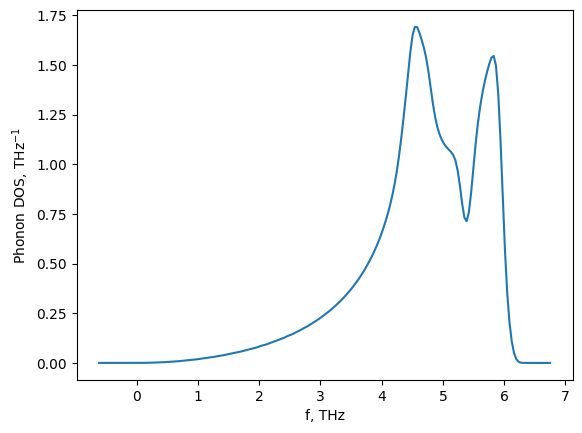

In [47]:
# calculate phonon
phonon_calculator = PhonopyCalculator(struc_opt)
phonon_calculator.calculate()
plt.plot(phonon_calculator.VALUE["dos_energies"], phonon_calculator.VALUE["dos_total"])
plt.xlabel("f, THz")
plt.ylabel("Phonon DOS, THz$^{-1}$")

In [48]:
# BCC high symmetry paths of the first Brillouin zone
path_bcc = [[[0, 0, 0], [0.5, -0.5, 0.5], [0.25, 0.25, 0.25], [0, 0, 0], [0, 0, 0.5]]]
labels_bcc = ["G", "H", "P", "G", "N"]

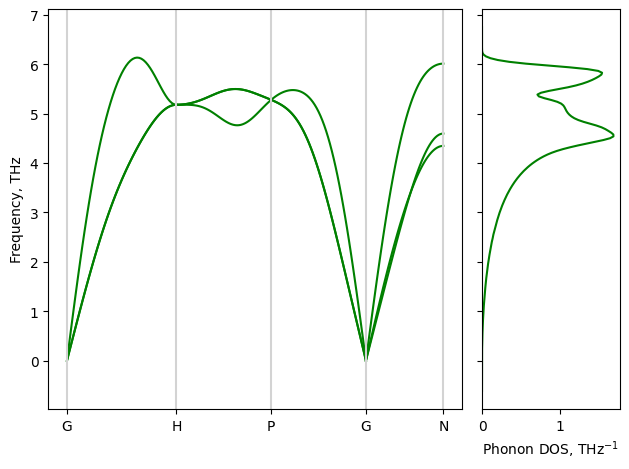

In [49]:
# phonon calculation of bcc structure
phonon_calculator.plot_band_structure_and_dos(path_bcc, labels_bcc, plot_kwargs={"color":"green"})
#plt.savefig("Frequency_fcc.png")

### E-V曲线

In [50]:
# Choose structures for E-V plot (Murnaghan)
s_murn=["hcp","fcc","bcc","dhcp"]

# 设置体积范围
Veq = 16
delV = 2
volume_range=[Veq-delV,Veq+delV]

In [51]:
strucs_murn=get_structures_dictionary(elm, include=s_murn)
murn={}
for struc in strucs_murn:
    print(struc)
    at=strucs_murn[struc]['atoms']
    at.set_calculator(calc)
    murn[struc]={"vol":[],"ene":[],"pre":[]}   
    vr = np.array(volume_range)*len(at)
    murn_calculator = MurnaghanCalculator(at,num_of_point=21,volume_range=vr)
    murn_calculator.calculate()
    murn[struc]["vol"]=murn_calculator.VALUE["volume"]/len(at)
    murn[struc]["ene"]=murn_calculator.VALUE["energy"]/len(at)
    murn[struc]["pre"]=murn_calculator.VALUE["pressure"]*eV_per_A3_to_GPa
    murn[struc]["eqstruc"]=murn_calculator.get_final_structure()

fcc
bcc
hcp
dhcp


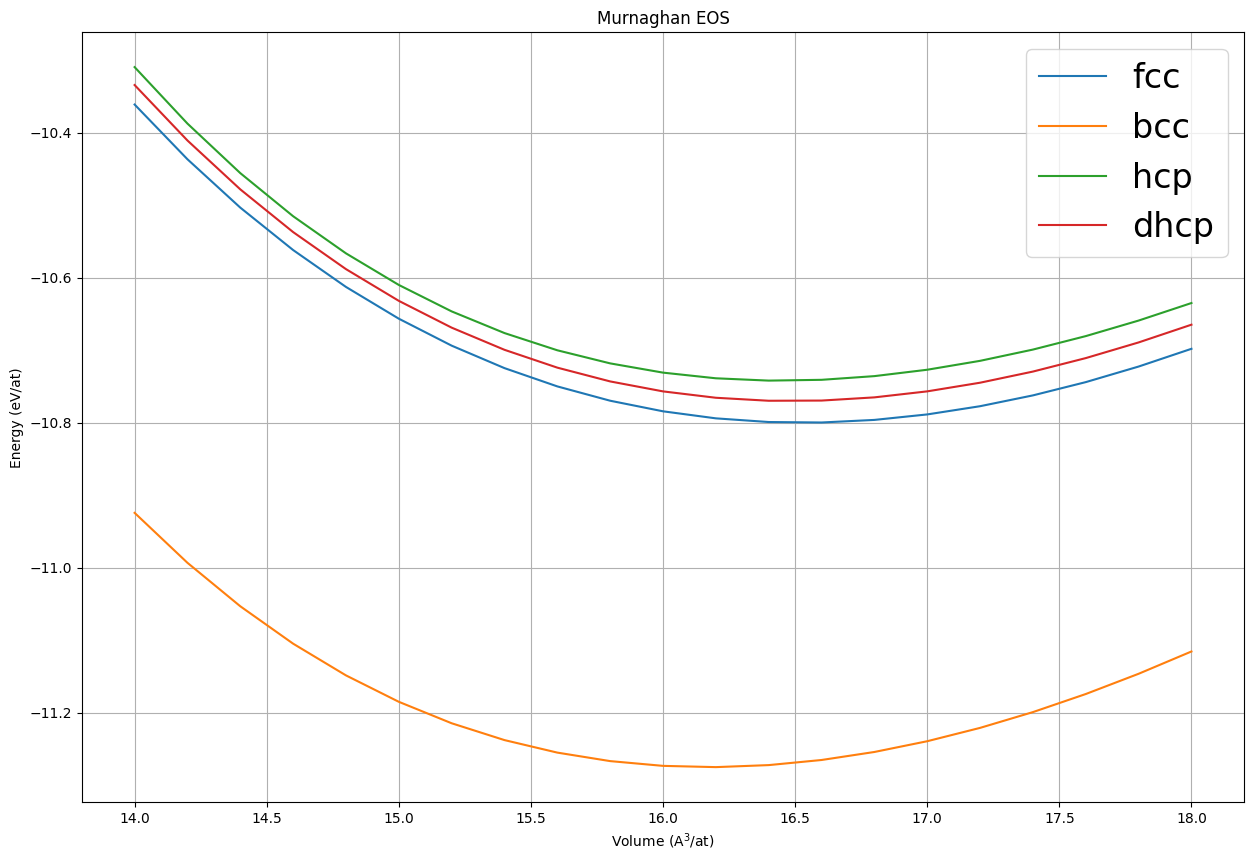

In [52]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["vol"],murn[struc]["ene"],label=struc)
plt.xlabel("Volume (A$^3$/at)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})

### E-P曲线

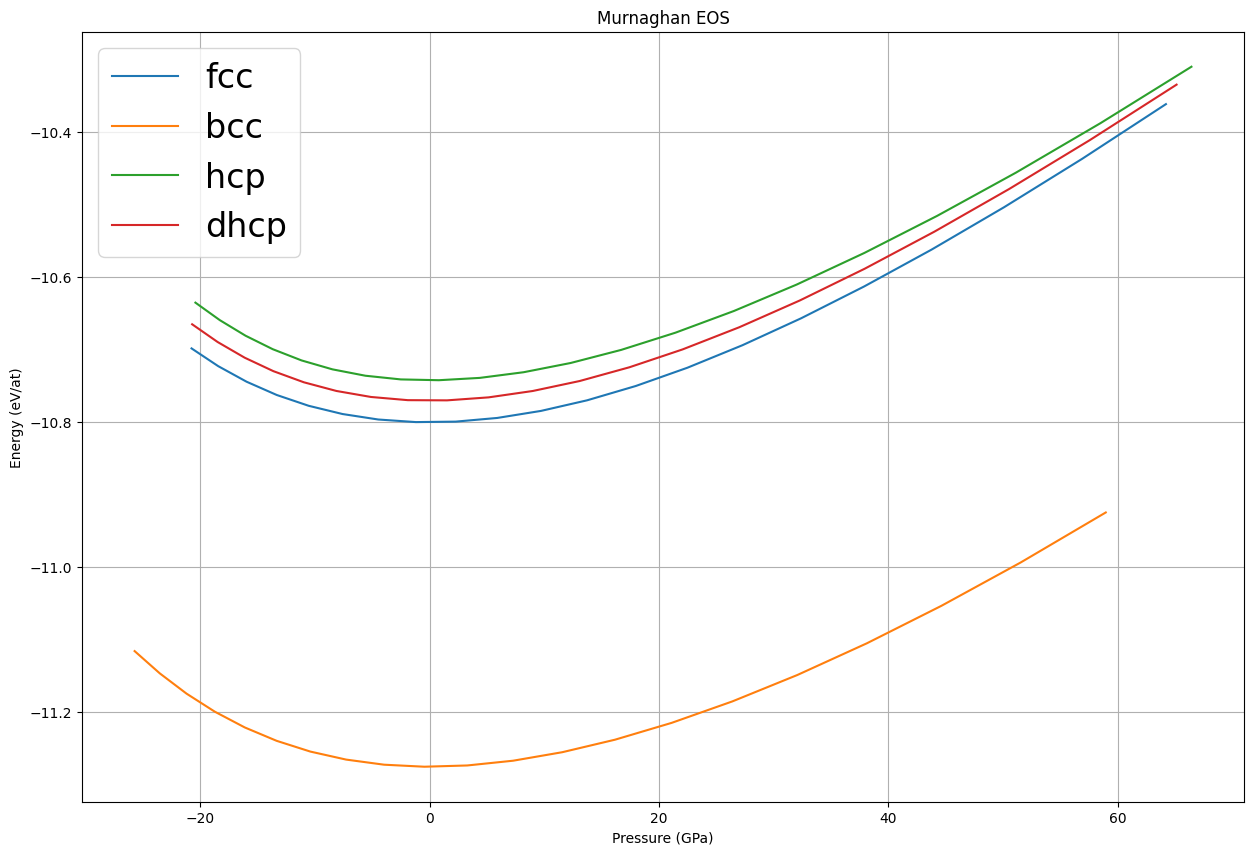

In [53]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["pre"],murn[struc]["ene"],label=struc)
plt.xlabel("Pressure (GPa)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
#plt.savefig("Energy_vs_Pressure.png")

### 构型信息

In [54]:
d = {}
for struc in strucs_murn:
    at=strucs_murn[struc]['atoms']
    stress_tmp=murn[struc]["eqstruc"].get_stress()*eV_per_A3_to_GPa*1000
    energy_tmp=murn[struc]["eqstruc"].get_potential_energy()/len(at)
    d1 = {struc:{'Latpars[A]': murn[struc]["eqstruc"].cell.lengths(), 'Principal stresses[MPa]': stress_tmp[0:3], 'Energy[eV]': energy_tmp}}
    d.update(d1)

In [55]:
dict2data = pd.DataFrame.from_dict(d, orient='index')
dict2data

,Latpars[A],Principal stresses[MPa],Energy[eV]
fcc,"[2.8593079219876705, 2.8593079219876705, 2.859...","[4.908627515224304, 4.908627515228804, 4.90862...",-10.799961
bcc,"[2.759379322356049, 2.759379322356049, 2.75937...","[-15.726518411103802, -15.726518411098196, -15...",-11.275141
hcp,"[2.8545749310854136, 2.8545749310854136, 4.661...","[2860.319210793159, 2860.319210793122, -5685.4...",-10.742040
dhcp,"[2.85688298286382, 2.85688298286382, 9.3305407...","[1640.7800455420354, 1640.7800455420559, -3240...",-10.770121


### Transformation paths

In [56]:
# Get the bcc structure and rescale it to the volume of the equilibrium fcc
struc_tmp = get_structures_dictionary(elm, include="bcc")
struc_bcc = struc_tmp["bcc"]["atoms"]
v_fcc = struc_opt.get_volume()
v_bcc = struc_bcc.get_volume()

cell = struc_bcc.get_cell()
new_cell = (v_fcc/v_bcc)**(1.0/3.0)*cell
struc_bcc.set_cell(new_cell, scale_atoms=True)
struc_bcc.set_calculator(calc)

trans_path_trig  = TransformationPathCalculator(struc_bcc, transformation_type="trigonal",num_of_point=100)
trans_path_hex   = TransformationPathCalculator(struc_bcc, transformation_type="hexagonal",num_of_point=100)
trans_path_tetra = TransformationPathCalculator(struc_bcc, transformation_type="tetragonal",num_of_point=100)
trans_path_ortho = TransformationPathCalculator(struc_bcc, transformation_type="orthogonal",num_of_point=100)
trans_path_trig.calculate()
trans_path_hex.calculate()
trans_path_tetra.calculate()
trans_path_ortho.calculate()

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


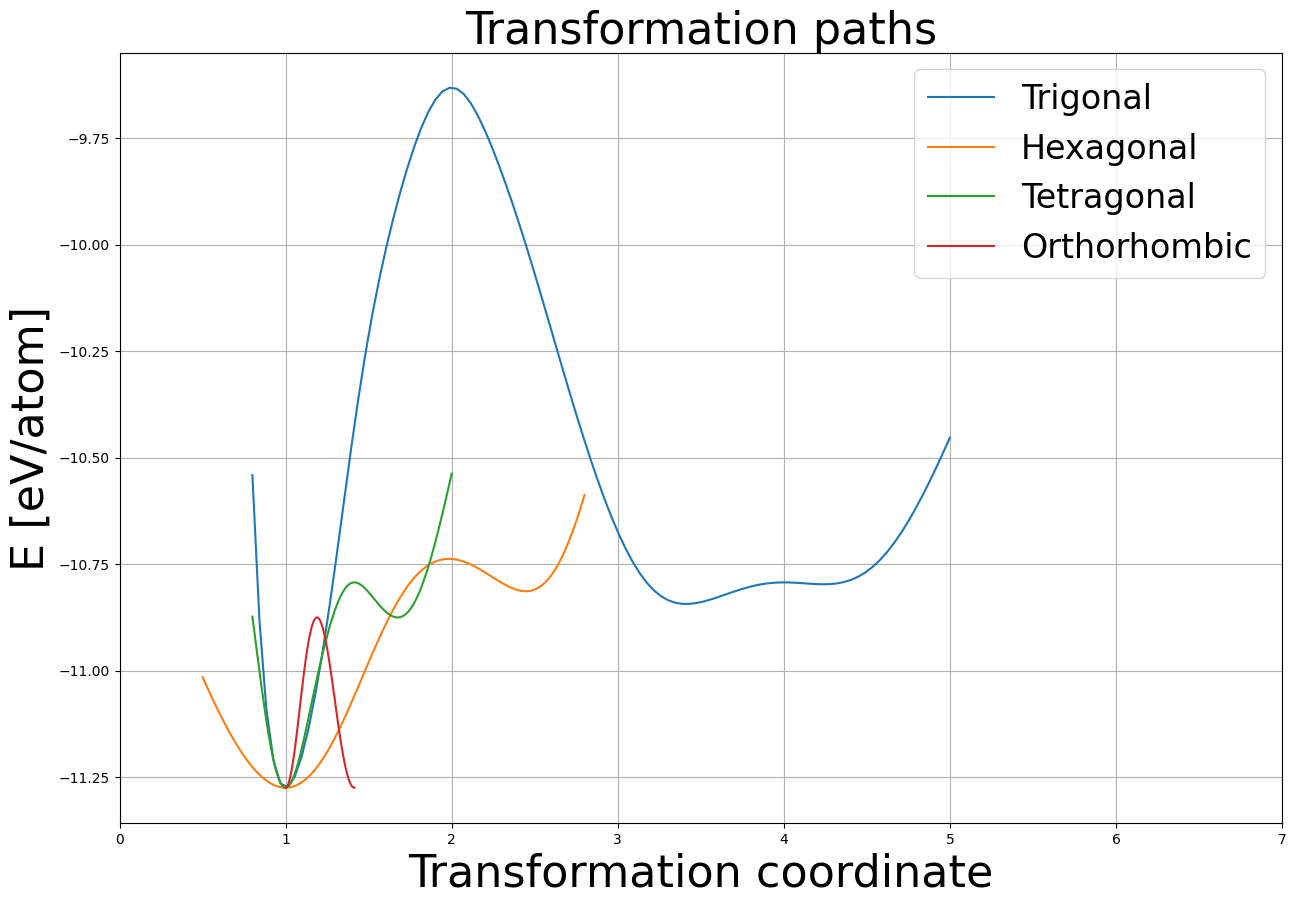

In [57]:
plt.figure(figsize=(15,10))
plt.plot(trans_path_trig.value['transformation_coordinates'],trans_path_trig.value['energies_0']/2.0,label="Trigonal")
plt.plot(trans_path_hex.value['transformation_coordinates']+1,trans_path_hex.value['energies_0']/4.0,label="Hexagonal")
plt.plot(trans_path_tetra.value['transformation_coordinates'],trans_path_tetra.value['energies_0']/2.0,label="Tetragonal")
plt.plot(trans_path_ortho.value['transformation_coordinates'],trans_path_ortho.value['energies_0']/4.0,label="Orthorhombic")

plt.title("Transformation paths", fontsize=32)
#plt.ylim(-4,-3)
plt.xlim(0,7)
plt.xlabel("Transformation coordinate", fontsize=32)
plt.ylabel("E [eV/atom]", fontsize=32)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
plt.savefig("Energy_vs_Transformation_coordinate.png")

### 基础性质总结-DFT对比

In [58]:
# ACE 信息
# lattice etc
opt_information = {"ACE": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}
# elastic constant
opt_information['ACE']['C11'] = elmat.VALUE["C"][0,0]
opt_information['ACE']['C22'] = elmat.VALUE["C"][0,1]
opt_information['ACE']['C33'] = elmat.VALUE["C"][3,3]
# bulk mudule
opt_information['ACE']['B'] = elmat.VALUE["BV"]
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    opt_information['ACE']["%10s"%i] = en_vac_ace
# surface energy
opt_information['ACE']['Surface(100) energy (J/m2)'] = surface100
opt_information['ACE']['Surface(110) energy (J/m2)'] = surface110
opt_information['ACE']['Surface(111) energy (J/m2)'] = surface111

In [59]:
# DFT 信息
# lattice etc
DFT_information = {"DFT": {"element": elm, "equil_structure": 'bcc', "No. of atoms": '1', "Lattice": '3.187', "Energy": '-11.252', "Maximum force": '0'}}
# elastic constant
DFT_information['DFT']['C11'] = '517'
DFT_information['DFT']['C22'] = '198'
DFT_information['DFT']['C33'] = '142'
# bulk mudule
DFT_information['DFT']['B'] = '304'
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    DFT_information['DFT']["%10s"%i] = '3.27'
# surface energy
DFT_information['DFT']['Surface(100) energy (J/m2)'] = '4.02'
DFT_information['DFT']['Surface(110) energy (J/m2)'] = '3.27'
DFT_information['DFT']['Surface(111) energy (J/m2)'] = '3.56'

In [60]:
opt_information.update(DFT_information)
dict_conclusion = pd.DataFrame.from_dict(opt_information)
dict_conclusion

,ACE,DFT
element,W,W
equil_structure,bcc,bcc
No. of atoms,1,1
Lattice,3.186311,3.187
Dimensions,"[2.7594259833171604, 2.75942598331716, 2.75942...",NaN
Angles,"[109.47122063449069, 109.47122063449069, 109.4...",NaN
Energy,-11.275141,-11.252
Maximum force,0,0
Stress 11,-0.0007555276130882311,NaN
Stress 22,-0.0007555276130255425,NaN


### 雷达图

In [61]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [62]:
#设置数据
df = {'Relative error':{}}
for key, value in dict_conclusion['DFT'].items():
    if not pd.isnull(value) and is_number(value) and value != '0':
        df['Relative error'][key] = (float(dict_conclusion['ACE'][key])-float(dict_conclusion['DFT'][key]))/float(dict_conclusion['DFT'][key])*100
    else:
        pass

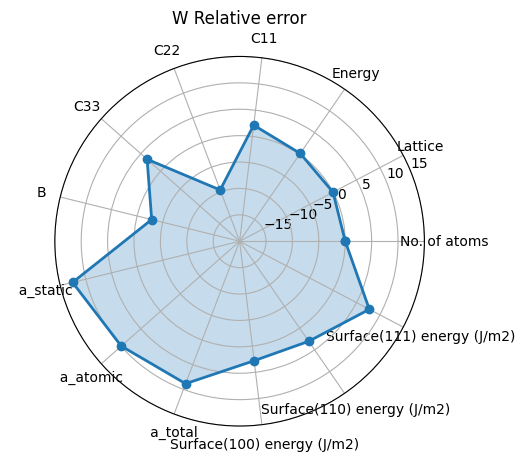

In [63]:
feature = list(df['Relative error'].keys())
values = list(df['Relative error'].values())
angles=np.linspace(0, 2*np.pi,len(feature), endpoint=False)
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))
# 绘图
fig=plt.figure()
# 设置为极坐标格式
ax = fig.add_subplot(111, polar=True)
# 绘制折线图
ax.plot(angles, values, 'o-', linewidth=2)
# 填充颜色
ax.fill(angles, values, alpha=0.25)
  
# 设置雷达图的范围
ax.set_ylim(-20,15)
# 添加标题
plt.title('W Relative error')
# 添加网格线
ax.grid(True)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature)
plt.show()


## CuW

In [64]:
# fcc 建模
L = 4
Cu3W = Atoms('WCu3', positions=[[0, 0, 0], [L/2, 0, L/2], [L/2, L/2, 0], [0, L/2, L/2]], cell=[L, L, L], pbc=[1, 1, 1])
CuW3 = Atoms('CuW3', positions=[[0, 0, 0], [L/2, 0, L/2], [L/2, L/2, 0], [0, L/2, L/2]], cell=[L, L, L], pbc=[1, 1, 1])
# bcc 建模
CuW = Atoms('CuW', positions=[[0, 0, 0], [L/2, L/2, L/2]], cell=[L, L, L], pbc=[1, 1, 1])

In [65]:
Cu3W.set_calculator(calc)
CuW.set_calculator(calc)
CuW3.set_calculator(calc)
murn1={}
murn1['Cu3W'] = Cu3W
murn1['CuW'] = CuW
murn1['CuW3'] = CuW3

In [66]:
murn = {}
delV = 8
Veq = 16
volume_range=[Veq-delV,Veq+delV]
for struc, struc_value in murn1.items(): 
    print(struc)
    vr = np.array(volume_range)*len(struc_value)
    Cu_count = struc_value.get_chemical_symbols().count('Cu')
    W_count = struc_value.get_chemical_symbols().count('W')
    murn[struc]={"vol":[],"ene":[],"pre":[]}
    murn_calculator = MurnaghanCalculator(struc_value, num_of_point=50, volume_range=vr)
    
    murn_calculator.calculate()
    murn[struc]["vol"]=murn_calculator.VALUE["volume"]/len(struc_value)
    murn[struc]["ene"]=(murn_calculator.VALUE["energy"]-Cu_count*E_refer_Cu-W_count*E_refer_W)/len(struc_value)
    murn[struc]["pre"]=murn_calculator.VALUE["pressure"]*eV_per_A3_to_GPa
    murn[struc]["eqstruc"]=murn_calculator.get_final_structure()
    # print(struc_value.get_chemical_symbols())
    # print(murn[struc]["ene"])
    # print(murn_calculator.VALUE["energy"])
    # print(Cu_count)
    # print(E_refer_Cu)
    # print(Cu_count*E_refer_Cu)


    

Cu3W
['W', 'Cu', 'Cu', 'Cu']
[3.61286316 3.05706059 2.59050813 2.19882273 1.87072468 1.59693952
 1.36967758 1.18227993 1.02897062 0.90475047 0.80547335 0.72770352
 0.66852039 0.62543432 0.59632434 0.57939059 0.57311237 0.57616019
 0.58730275 0.60542169 0.62951465 0.65869332 0.692178   0.72929008
 0.7694438  0.81213829 0.85694964 0.90352624 0.95158932 1.000906
 1.05127433 1.10251558 1.15446864 1.20698602 1.25993121 1.31317673
 1.36660283 1.42009658 1.47355136 1.52686695 1.57995011 1.63271577
 1.68508858 1.73700429 1.78840938 1.83926115 1.8895279  1.93918829
 1.9882299  2.03664737]
[ -7.95386361 -10.1770739  -12.04328371 -13.61002533 -14.92241753
 -16.01755814 -16.9266059  -17.67619652 -18.28943375 -18.78631436
 -19.18342285 -19.49450215 -19.73123469 -19.90357894 -20.02001886
 -20.08775386 -20.11286676 -20.10067548 -20.05610524 -19.98362949
 -19.88725764 -19.77054297 -19.63660422 -19.48815591 -19.32754103
 -19.15676308 -18.97751767 -18.79121129 -18.59895898 -18.40169224
 -18.20021892 -17

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


['Cu', 'W']
[5.7471455  4.90126379 4.17530473 3.55671933 3.0319684  2.58751282
 2.21101008 1.89221493 1.62282706 1.39627219 1.20744486 1.05225031
 0.92711869 0.8285673  0.75317638 0.69772188 0.65929362 0.63540647
 0.62406225 0.62373789 0.6333012  0.65188065 0.67873004 0.71312263
 0.7542555  0.80127737 0.85335929 0.90971107 0.96957717 1.03227184
 1.09720573 1.16388941 1.23192928 1.30101765 1.37091915 1.44145571
 1.5124922  1.58392372 1.65566542 1.72764496 1.79979727 1.87206138
 1.94437941 2.01669939 2.08897094 2.16114342 2.23316664 2.30499198
 2.37657326 2.44786737]
[ -3.4909085   -5.18267192  -6.63459004  -7.87176083  -8.92126269
  -9.81017385 -10.56317933 -11.20076963 -11.73954537 -12.19265511
 -12.57030976 -12.88069887 -13.13096211 -13.32806489 -13.47884673
 -13.58975573 -13.66661224 -13.71438654 -13.73707499 -13.73772371
 -13.7185971  -13.68143819 -13.6277394  -13.55895424 -13.47668849
 -13.38264475 -13.27848091 -13.16577734 -13.04604516 -12.92065582
 -12.79078803 -12.65742067 -12.5

Equilibrum lattice parameters and stresses of optimized structures


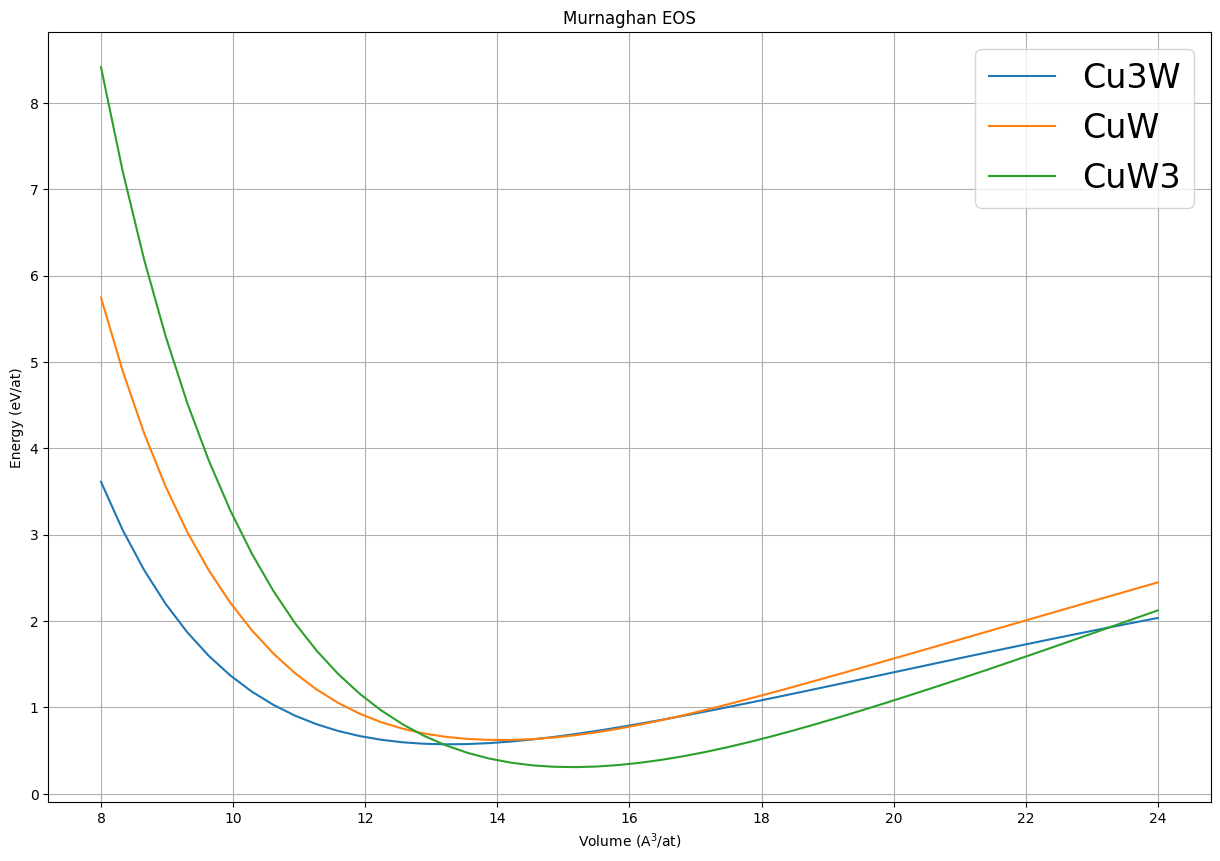

In [67]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc, struc_value in murn1.items(): 
    plt.plot(murn[struc]["vol"],murn[struc]["ene"],label=struc)
plt.xlabel("Volume (A$^3$/at)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
plt.savefig("Energy_vs_Volume2.png")

print("Equilibrum lattice parameters and stresses of optimized structures")